# Data-Centric AI Competition
## 03 - Data Augmentation

- https://pytorch.org/vision/stable/transforms.html (Documentation)
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html (Visual examples of transforms)
- https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4
- https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html
- https://appen.com/blog/how-to-create-training-data-for-computer-vision-use-cases/
- https://medium.com/swlh/image-processing-with-python-image-segmentation-using-thresholding-methods-423ecdaf8ab4

#### Ideas
- [**✓ DONE**] Generate more data up to the max 10,000 limit, and also give equal number of examples for each label
- [**✓ DONE**] Mix all train and val together, augment, then do 70/30 split for train and test (since val images look quite nice, Discovered this when doing manual cleaning by browsing folders)
- [**✓ DONE**] Horizontal flip for labels i, ii, iii, v, x
- [**✓ DONE**] Add random Gaussian noise (https://www.kaggle.com/parulpandey/overview-of-popular-image-augmentation-packages)
- [**✓ DONE**] Try random order in IAA sequential
- [**✓ DONE**] Vertical flip for labels i, ii, iii, ix, x
- [**✓ DONE**] Review previously deleted photos + Further data cleaning of existing images
- [**✓ DONE**] KIV remove random order? See if fixed order for all transformations work
- [**✓ DONE**] Try CV2 morphological operations
- [**✓ DONE**] Include RandomPerspective (eg. RandomPerspective(distortion_scale, p) of Torchvision), and reduce the contrast jitter since the test images may not have such contrast
- [**✓ DONE**] Increase size from 400x400 to 500x500
- Otsu thresholding. Explore how individual histograms look like for selected images
- Add Grids lines as artifacts?
- Create respective folder after identifying edge cases, and generate more examples from there e.g. 20% is edge cases while 80% is everything mixed in
- Relook at clean images again for inspiration
- [**SKIP**] Try excessive translate (aug = iaa.Affine(translate_percent={"x": -0.20}, mode=ia.ALL, cval=(0, 255))) from https://imgaug.readthedocs.io/en/latest/source/overview/geometric.html


___
<a name="top"></a>
### Submission Tracker

Submission 00 - Cleaned data (Score: 0.68182)  
[Submission 1](#v1) **(Score: 0.78926)**  
[Submission 2](#v2) **(Score: 0.81570)**       
[Submission 3](#v3) **(Score: 0.82107)**       
[Submission 4](#v4) **(Score: 0.83471)**   
[Submission 5](#v5) **(Score: 0.83966)**   
[Submission 6](#v6) **(Score: 0.82066)**   
[Submission 7](#v7) **(Score: 0.82438)**   
[Submission 8](#v8) **(Score: Bundle failed)**    
[Submission 9](#v9) **(Score: ____)**  
[Submission 10](#v10) **(Score: ____)**   
[Submission 11](#v11) **(Score: ____)**   
[Submission 12](#v12) **(Score: ____)**    
[Submission 13](#v13) **(Score: ____)**    
[Submission 14](#v14) **(Score: ____)**  
[Submission 15](#v15) **(Score: ____)**  
[Submission 16](#v16) **(Score: ____)**  
[Submission 17](#v17) **(Score: ____)**  
[Submission 18](#v18) **(Score: ____)**  
[Submission 19](#v19) **(Score: ____)**  

### Lessons
- Small dataset, can just move or delete images from Windows folder. Don't really need to spend so much time scripting to do these image file movement
- Shift all deleted files into a common folder, so that they can be reviewed later on (Instead of totally deleting them off the system)
- Rename files with prefix early on, even if they are already in the respective train/valid folders
- Mix train and valid since valid dataset appeared to have nicer photos
- Important to manually review how the augmented images look
- Limit is 10000, so it is important to maximize the quantity (Remember the concept of Quality, Quantity and Variety)
- Vital to keep track/document the details of the changes made (so that the score changes can be accounted for)

#### Initial setup

In [71]:
# pip install torch torchvision # (For CPU)
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torchvision import datasets, models            # vision datasets,architectures & transforms
import torchvision.transforms as T                  # composable transforms
torch.manual_seed(42)
import imgaug as ia
from imgaug import augmenters as iaa
import os
from pathlib import Path
from glob import glob
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
from scipy.ndimage.interpolation import shift
from skimage.filters import threshold_otsu

# Define locations of cleaned data to perform augmentation on
CLEAN_DATA_FOLDER = 'data/1_clean'
TRAIN_DATA = f'{CLEAN_DATA_FOLDER}/train'
VALID_DATA = f'{CLEAN_DATA_FOLDER}/val'

# Set seed
ia.seed(1)

In [2]:
# Add prefix for all images depending on the dataset type (to prevent overwrite when combined in a folder)
# Add t_ for training data and v_ for validation data
# Already done, so no need to rerun this script

# datasets = [TRAIN_DATA, VALID_DATA]

# for dataset_folder in datasets:
#     for label_folder in os.listdir(dataset_folder):
#         for file in os.listdir(dataset_folder+'/'+label_folder):
#             if file.startswith('t_') or file.startswith('v'):
#                 pass # If prefix already renamed, skip
#             else:
            
#                 dataset_type = dataset_folder.split('/')[-1]
#                 if dataset_type == 'train':
#                     new_name = 't_' + file
#                 else:
#                     new_name = 'v_' + file

#                 filename_original = os.path.join(dataset_folder, label_folder, file)
#                 filename_new = os.path.join(dataset_folder, label_folder, new_name)
#                 os.rename(filename_original, filename_new)

#### Setup utility functions 

In [3]:
# Function to show a random set of images
def show_images(label, num):
    images = []
    labels = []
    filenames = []

    # Add train data images
    data_folders = [TRAIN_DATA, VALID_DATA]
    
    for data_folder in data_folders:
        for folder in os.listdir(data_folder):
              for image in os.listdir(data_folder + '/' + label):
                images.append(os.path.join(data_folder, label, image))
                if data_folder == TRAIN_DATA:
                    filenames.append(f'train/{label}/{image}')
                else:
                    filenames.append(f'val/{label}/{image}')

    plt.figure(1, figsize=(18, 11))
    plt.axis('off')
    n = 0

    for i in range(num):
        n += 1
        random_index = random.choice(range(len(images)))
        random_filename = filenames[random_index]
        random_img = images[random_index]
        img = cv2.imread(random_img, cv2.IMREAD_GRAYSCALE)
        plt.subplot(np.sqrt(num), np.sqrt(num), n)
        plt.axis('off')
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        random_data_type = random_filename.split('/')[0]
        random_img_name = random_filename.split('/')[-1].split('.')[0]
        plt.title(f'{random_data_type}-{random_img_name}')
    plt.show()

In [61]:
# Function to get 1 random image (from training set) and compare with transformed image
def show_single_transform(transform, show_histogram=False):
    images = []
    filenames = []
    
    for folder in os.listdir(TRAIN_DATA):
          for image in os.listdir(TRAIN_DATA + '/' + folder):
            images.append(os.path.join(TRAIN_DATA, folder, image))
            filenames.append(f'train/{folder}/{image}')
            
    random_index = random.choice(range(len(images)))
    random_filename = filenames[random_index]
    random_img = images[random_index]
    
    img_original = Image.open(random_img)
    img_original = ImageOps.grayscale(img_original) # applying greyscale method

    # Execute transformation
    try:
        img_transformed = transform(img_original)
    except:
        img_transformed = transform(images=np.asarray(img_original))
    print(f'Transformation successful')
        
    # Display images side by side
    fig = plt.figure(figsize=(14, 8))

    # show original image
    fig.add_subplot(221)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img_original, cmap=plt.get_cmap('gray'))
    
    fig.add_subplot(222)
    plt.title('Transformed Image')
    plt.axis('off')
    plt.imshow(img_transformed, cmap=plt.get_cmap('gray'))
    
    if show_histogram==True:
        hist_original = cv2.calcHist([np.asarray(img_original)],[0],None,[256],[0,256])
        hist_transformed = cv2.calcHist([np.asarray(img_transformed)],[0],None,[256],[0,256])
        
        fig.add_subplot(223)
        plt.title('Histogram of Original')
        plt.plot(hist_original)
        
        fig.add_subplot(224)
        plt.title('Histogram of Transformed')
        plt.plot(hist_transformed)
    
    plt.show();

#### Create functions for batch image transformation/augmentation

In [5]:
# Mass transform images from input folder into specific number of examples (i.e. 700 train/300 val for each of the 10 labels)
def augment_images(dataset_type, label, transform, aug_version):
    input_folder = f'data/1_clean/{dataset_type}/{label}'
    output_folder = f'data/2_augmented_{aug_version}/{dataset_type}/{label}'
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    input_files = glob(os.path.join(input_folder, "*.png"))
    print(f'Created output folder: {output_folder}')
    
    # For every image, do 1 transformations so as to double the original image count
    # After that, for the balance number after subtracting from 700 (train) or 300 (validation) for 70/30 split,
    # generate random images from the original image count to make up the numbers to hit 10000 total images
    for f in input_files:
        img_name = f.split('\\')[-1].split('.')[0]
        img_original = Image.open(f)
        img_original = ImageOps.grayscale(img_original)
        transformed_image_1 = transform(img_original)       
        transformed_image_2 = transform(img_original) 
        transformed_image_1.save(f'{output_folder}/{img_name}_1.png', 'PNG')
        transformed_image_2.save(f'{output_folder}/{img_name}_2.png', 'PNG')

    output_folder_count = len(os.listdir(output_folder))
    if dataset_type == 'train':
        balance_count = 700 - output_folder_count
    else:
        balance_count = 300 - output_folder_count

    n = 0
    for i in range(balance_count):
        n += 1
        random_index = random.choice(range(len(input_files)))
        random_file = input_files[random_index]
        img_random = Image.open(random_file)
        img_random = ImageOps.grayscale(img_random)
        
        # Execute transformation
        try:
            transformed_img_random = transform(img_random)
        except:
            transformed_img_random = transform(images=np.asarray(img_random))
            
        # Convert back to PIL to save
        transformed_img_random = Image.fromarray(transformed_img_random)                
        transformed_img_random.save(f'{output_folder}/{label}_random{n}.png', 'PNG')

    print(f'Final {dataset_type} ({label}) folder count = {len(os.listdir(output_folder))}')

In [102]:
# Mixing train and valid sets together first, perform augmentation, and then splitting
# Done because manual inspection showed val dataset had many 'good-looking' images that is worth using for training
def augment_images_shuffle(label, transform, aug_version, 
                           total_size=1000, train_size=700,
                           extra_transform=None):

    # Setup relevant folder paths    
    input_folder_train = f'./{CLEAN_DATA_FOLDER}/train/{label}'
    input_folder_valid = f'./{CLEAN_DATA_FOLDER}/val/{label}'
    
    # Create temporary folder for input images specific label (with all train and val images)
    temp_folder = f'./data/2_augmented_{aug_version}/temp_{label}'
    Path(temp_folder).mkdir(parents=True, exist_ok=True)
   
    # Copy all clean images into temp folder
    input_folders = [input_folder_train, input_folder_valid]
    
    for input_folder in input_folders:
        for image in os.listdir(input_folder):
            # Copy the contents of source to destination 
            dataset_type = input_folder.split('/')[-2] # Train or valid set
            shutil.copy(f'{input_folder}/{image}', temp_folder)

    # Create output folder paths
    output_folder_train = f'./data/2_augmented_{aug_version}/train/{label}'
    output_folder_val = f'./data/2_augmented_{aug_version}/val/{label}'
    Path(output_folder_train).mkdir(parents=True, exist_ok=True)
    Path(output_folder_val).mkdir(parents=True, exist_ok=True)
        
    input_files = glob(os.path.join(temp_folder, "*.png"))
    print(f'Created temp folder: {temp_folder}')
    
    # For every image, do random transformations until hit the 1000 image mark (for each label)
    temp_folder_count = len(os.listdir(temp_folder))
    
    # Calculate number of additional images to generate to top up to 1000 images
    balance_count = total_size - temp_folder_count

    n = 0
    for i in range(balance_count):
        n += 1
        random_index = random.choice(range(len(input_files)))
        random_file = input_files[random_index]
        img_random = Image.open(random_file)
        img_random = ImageOps.grayscale(img_random)

        # Execute transformation (IAA)
        try:
            transformed_img_random = transform(img_random)
        except:
            transformed_img_random = transform(images=np.asarray(img_random))   
            
        # Perform additional morphological operation (e.g. CV2 morphs)
        if extra_transform is not None:
            transformed_img_random = extra_transform(transformed_img_random)
        
        # Convert back to PIL to save
        transformed_img_random = Image.fromarray(transformed_img_random)       
        transformed_img_random.save(f'{temp_folder}/{label}_random_{n}.png', 'PNG')
        
    # Random assign images into train and validation folders (for every label)
    full_img_list = [file for file in os.listdir(temp_folder)]
    print(len(full_img_list))
    train_list = random.sample(full_img_list, train_size)
    val_list = [x for x in full_img_list if x not in train_list]

    for file in train_list:
        shutil.copy(os.path.join(temp_folder, file), output_folder_train)
    for file in val_list:
        shutil.copy(os.path.join(temp_folder, file), output_folder_val)
    
    # Delete temporary folder
    shutil.rmtree(temp_folder, ignore_errors=True)

In [7]:
# Same as above but make sure every image is worked on at least twice
def augment_images_shuffle_full_repr(label, transform, aug_version, 
                                       total_size=1000, train_size=700,
                                       extra_transform=None):

    # Setup relevant folder paths    
    input_folder_train = f'./{CLEAN_DATA_FOLDER}/train/{label}'
    input_folder_valid = f'./{CLEAN_DATA_FOLDER}/val/{label}'
    
    # Create temporary folder for input images specific label (with all train and val images)
    temp_folder = f'./data/2_augmented_{aug_version}/temp_{label}'
    Path(temp_folder).mkdir(parents=True, exist_ok=True)
   
    # Copy all clean images into temp folder
    input_folders = [input_folder_train, input_folder_valid]
    
    for input_folder in input_folders:
        for image in os.listdir(input_folder):
            # Copy the contents of source to destination 
            dataset_type = input_folder.split('/')[-2] # Train or valid set
            shutil.copy(f'{input_folder}/{image}', temp_folder)

    # Create output folder paths
    output_folder_train = f'./data/2_augmented_{aug_version}/train/{label}'
    output_folder_val = f'./data/2_augmented_{aug_version}/val/{label}'
    Path(output_folder_train).mkdir(parents=True, exist_ok=True)
    Path(output_folder_val).mkdir(parents=True, exist_ok=True)
        
    input_files = glob(os.path.join(temp_folder, "*.png"))
    print(f'Created temp folder: {temp_folder}')
    
    # Add code to make sure every image is transformed at least twice before
    # random image generation sets in
    for f in input_files:
        img_name = f.split('\\')[-1].split('.')[0]
        img_original = Image.open(f)
        img_original = ImageOps.grayscale(img_original)
        
        # Execute transformation (IAA)
        try:      
            transformed_image_2 = transform(img_original)
        except:      
            transformed_image_2 = transform(images=np.asarray(img_original))           

        # Perform random CV2 morphological operation
        if extra_transform is not None:   
            transformed_image_2 = extra_transform(transformed_image_2) 
         
        transformed_image_2 = Image.fromarray(transformed_image_2) 
        transformed_image_2.save(f'{temp_folder}/{img_name}_2.png', 'PNG')
    
    # Prepare to generate random transformations until hit 1000 image mark (for each label)
    temp_folder_count = len(os.listdir(temp_folder))
    
    # Calculate number of additional images to generate to top up to 1000 images
    balance_count = total_size - temp_folder_count

    n = 0
    for i in range(balance_count):
        n += 1
        random_index = random.choice(range(len(input_files)))
        random_file = input_files[random_index]
        img_random = Image.open(random_file)
        img_random = ImageOps.grayscale(img_random)

        # Execute transformation (IAA)
        try:
            transformed_img_random = transform(img_random)
        except:
            transformed_img_random = transform(images=np.asarray(img_random))   
            
        # Perform random CV2 morphological operation
        if extra_transform is not None:
            transformed_img_random = extra_transform(transformed_img_random)
        
        # Convert back to PIL to save
        transformed_img_random = Image.fromarray(transformed_img_random)       
        transformed_img_random.save(f'{temp_folder}/{label}_random_{n}.png', 'PNG')
        
    # Random assign 700 images into train and 300 in validation (for every label)
    full_img_list = [file for file in os.listdir(temp_folder)]
    print(len(full_img_list))
    train_list = random.sample(full_img_list, train_size)
    val_list = [x for x in full_img_list if x not in train_list]

    for file in train_list:
        shutil.copy(os.path.join(temp_folder, file), output_folder_train)
    for file in val_list:
        shutil.copy(os.path.join(temp_folder, file), output_folder_val)
    
    # Delete temporary folder
    shutil.rmtree(temp_folder, ignore_errors=True)

#### Get count of images in train and val sets

In [6]:
train_img_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(TRAIN_DATA) for filename in filenames])
valid_img_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(VALID_DATA) for filename in filenames])
print(f'Number of train images: {train_img_count}')
print(f'Number of validation images: {valid_img_count}')
print(f'Total number of images: {train_img_count + valid_img_count}')

Number of train images: 1903
Number of validation images: 802
Total number of images: 2705


- Current split approximately at 70:30 (70 train/30 val)  
- Aim to keep this split post augmentation, but maximize total images to the max limit of 10,000
- Own plan is to have equal number of examples for each label  
- Final target count: 7000 train/ 3000 validation i.e. 700 train and 300 val for each of the 10 labels

In [7]:
all_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']

for label in all_labels:
    train_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(f'{TRAIN_DATA}/{label}') for filename in filenames])
    print(f'Train count - {label}: {train_count}')
    valid_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(f'{VALID_DATA}/{label}') for filename in filenames])
    print(f'Valid count - {label}: {valid_count}')

Train count - i: 245
Valid count - i: 81
Train count - ii: 162
Valid count - ii: 86
Train count - iii: 148
Valid count - iii: 81
Train count - iv: 262
Valid count - iv: 85
Train count - v: 180
Valid count - v: 76
Train count - vi: 168
Valid count - vi: 79
Train count - vii: 177
Valid count - vii: 75
Train count - viii: 172
Valid count - viii: 80
Train count - ix: 215
Valid count - ix: 78
Train count - x: 174
Valid count - x: 81


___
<a name="v1"></a>
## Augmentation - Version 1
[Back to Top](#top)
___
**Description**  
- Simple initial augmentations with random affine and color jitter

**Transform Details**
- Random Affine + Color Jitter for all labels (i to x)

**Status**  
- Submitted on 30 Jul 2021 (Zip filename: submission-v01.zip)
- **Score: 0.78926**

Transformation successful


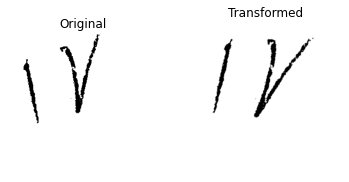

In [13]:
transform_v1 = T.Compose([T.Resize(size=(512,512)),
                                  T.RandomAffine(degrees=30, 
                                                 translate=(0.06, 0.06),
                                                 scale=(.8, 1.3),
                                                 shear=0,
                                                 fill=255),
                                  T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                                            ])

show_single_transform(transform_v1)

In [15]:
# dataset_types = ['train', 'val']
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']

# for dataset_type in dataset_types:
#     for target_label in target_labels:
#         augment_images(dataset_type, target_label, transform_v1, 'v1')

Created output folder: data/2_augmented_v1/train/i
Final train (i) folder count = 700
Created output folder: data/2_augmented_v1/train/ii
Final train (ii) folder count = 700
Created output folder: data/2_augmented_v1/train/iii
Final train (iii) folder count = 700
Created output folder: data/2_augmented_v1/train/iv
Final train (iv) folder count = 700
Created output folder: data/2_augmented_v1/train/v
Final train (v) folder count = 700
Created output folder: data/2_augmented_v1/train/vi
Final train (vi) folder count = 700
Created output folder: data/2_augmented_v1/train/vii
Final train (vii) folder count = 700
Created output folder: data/2_augmented_v1/train/viii
Final train (viii) folder count = 700
Created output folder: data/2_augmented_v1/train/ix
Final train (ix) folder count = 700
Created output folder: data/2_augmented_v1/train/x
Final train (x) folder count = 700
Created output folder: data/2_augmented_v1/val/i
Final val (i) folder count = 300
Created output folder: data/2_augmen

___
<a name="v2"></a>
## Augmentation - Version 2
[Back to Top](#top)
___
**Description**
- Start with train/validation data shuffle (combine all, augment, and then random split 70/30 into separate train/val folders)
- Use IAA instead of Torchvision
- Implementing imgaug's proposed simple augmentation sequence (with minor adjustments) (https://imgaug.readthedocs.io/en/latest/source/examples_basics.html#a-simple-and-common-augmentation-sequence)
- Perform horizontal flip for only labels i, ii, iii, v, x

**Status**
- Submitted on 01 Aug 2021
- **Score: 0.81570**

In [15]:
transform_v2a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}), # Not part of original seq in documentation
                    iaa.Crop(percent=(0, 0.05)), # random crops (original was (0, 0.1))
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.LinearContrast((1.35, 1.75)), # Original was (0.75, 1.5)
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)}, # Original is (-0.2, 0.2) for both
                        rotate=(-20, 20), # Original value is (-25,25)
                        shear=(-3, 3), # Original value is (-8,8)
                        cval=255
                    )
                ], random_order=True)

Transformation successful


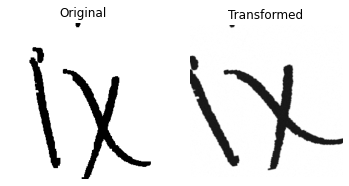

In [17]:
# Function to include horizontal flip (only for labels i, ii, iii, v, x)
transform_v2b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip 
                    iaa.Resize({"height": 400, "width": 400}), # Not part of original seq in documentation
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)

# Single transform
show_single_transform(transform_v2a)

In [196]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_to_flip = ['i','ii','iii','v','x']

# for target_label in target_labels:
#     if target_label in labels_to_flip:
#         augment_images_shuffle(label=target_label, 
#                                     transform=transform_v2b, 
#                                     aug_version='v02')
#     else:
#         augment_images_shuffle(label=target_label, 
#                                     transform=transform_v2a, 
#                                     aug_version='v02')

Created temp folder: ./data/2_augmented_v02/temp_i
1000
Created temp folder: ./data/2_augmented_v02/temp_ii
1000
Created temp folder: ./data/2_augmented_v02/temp_iii
1000
Created temp folder: ./data/2_augmented_v02/temp_iv
1000
Created temp folder: ./data/2_augmented_v02/temp_v
1000
Created temp folder: ./data/2_augmented_v02/temp_vi
1000
Created temp folder: ./data/2_augmented_v02/temp_vii
1000
Created temp folder: ./data/2_augmented_v02/temp_viii
1000
Created temp folder: ./data/2_augmented_v02/temp_ix
1000
Created temp folder: ./data/2_augmented_v02/temp_x
1000


___
<a name="v3"></a>
### Augmentation - Version 3
[Back to Top](#top)
___
**Description**
- Continue with data shuffle (train/val mix) and IAA baseline basic augmentation
- Continue with horizontal flips for 'i','ii','iii','v','x'
- Introduce vertical flips for i, ii, iii, ix, x
- Summary:
  - (a) No flip: iv, vi, vii, viii
  - (b) Horizontal flip only: v
  - (c) Vertical flip only: ix
  - (d) Vertical AND horizontal flips: i, ii, iii, x  

**Status**
- Submitted on 1 Aug 2021
- **Score: 0.8210743801652892**

In [19]:
# No flip: iv, vi, vii, viii
transform_v3a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal flip only: v
transform_v3b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Vertical flip only: ix
transform_v3c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v3d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)

Transformation successful


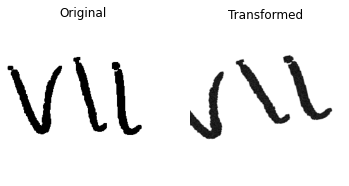

In [20]:
# Single transform
show_single_transform(transform_v3c)

In [200]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v3a, 
#                                aug_version='v03')
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v3b, 
#                                aug_version='v03')
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v3c, 
#                                aug_version='v03')
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v3d, 
#                                aug_version='v03')

Created temp folder: ./data/2_augmented_v03/temp_i
1000
Created temp folder: ./data/2_augmented_v03/temp_ii
1000
Created temp folder: ./data/2_augmented_v03/temp_iii
1000
Created temp folder: ./data/2_augmented_v03/temp_iv
1000
Created temp folder: ./data/2_augmented_v03/temp_v
1000
Created temp folder: ./data/2_augmented_v03/temp_vi
1000
Created temp folder: ./data/2_augmented_v03/temp_vii
1000
Created temp folder: ./data/2_augmented_v03/temp_viii
1000
Created temp folder: ./data/2_augmented_v03/temp_ix
1000
Created temp folder: ./data/2_augmented_v03/temp_x
1000


___
<a name="v4"></a>
### Augmentation - Version 4
[Back to Top](#top)
___
**Description**
- Perform additional manual data cleaning (Review past deleted images and add back if need be, and review existing ones). 
- Added label book data as well (into train set)
- Adjust train test split (try 80/20)

**Status**
- Submitted on 6 Aug 2021
- **Score: 0.83471**

In [22]:
# No flip: iv, vi, vii, viii
transform_v4a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal flip only: v
transform_v4b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Vertical flip only: ix
transform_v4c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v4d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)

In [24]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v4a, 
#                                 aug_version='v04',
#                                 train_size=800)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v4b, 
#                                 aug_version='v04',
#                                 train_size=800)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v4c, 
#                                 aug_version='v04',
#                                 train_size=800)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v4d, 
#                                 aug_version='v04',
#                                 train_size=800)

Created temp folder: ./data/2_augmented_v04/temp_i
1000
Created temp folder: ./data/2_augmented_v04/temp_ii
1000
Created temp folder: ./data/2_augmented_v04/temp_iii
1000
Created temp folder: ./data/2_augmented_v04/temp_iv
1000
Created temp folder: ./data/2_augmented_v04/temp_v
1000
Created temp folder: ./data/2_augmented_v04/temp_vi
1000
Created temp folder: ./data/2_augmented_v04/temp_vii
1000
Created temp folder: ./data/2_augmented_v04/temp_viii
1000
Created temp folder: ./data/2_augmented_v04/temp_ix
1000
Created temp folder: ./data/2_augmented_v04/temp_x
1000


___
<a name="v5"></a>
### Augmentation - Version 5
[Back to Top](#top)
___
**Description**
- Remove random order
- Otherwise, keep all same as Version 4 i.e. Train test split 80/20, cleaned data and also added label book data

**Status**
- Submitted on 6 Aug 2021
- **Score: 0.83966**

In [25]:
# No flip: iv, vi, vii, viii
transform_v5a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v5b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v5c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v5d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)

In [26]:
# # Remove random order
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v5a, 
#                                 aug_version='v05',
#                                 train_size=800)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v5b, 
#                                 aug_version='v05',
#                                 train_size=800)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v5c, 
#                                 aug_version='v05',
#                                 train_size=800)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v5d, 
#                                 aug_version='v05',
#                                 train_size=800)

Created temp folder: ./data/2_augmented_v05/temp_i
1000
Created temp folder: ./data/2_augmented_v05/temp_ii
1000
Created temp folder: ./data/2_augmented_v05/temp_iii
1000
Created temp folder: ./data/2_augmented_v05/temp_iv
1000
Created temp folder: ./data/2_augmented_v05/temp_v
1000
Created temp folder: ./data/2_augmented_v05/temp_vi
1000
Created temp folder: ./data/2_augmented_v05/temp_vii
1000
Created temp folder: ./data/2_augmented_v05/temp_viii
1000
Created temp folder: ./data/2_augmented_v05/temp_ix
1000
Created temp folder: ./data/2_augmented_v05/temp_x
1000


___
<a name="v6"></a>
### Augmentation - Version 6
[Back to Top](#top)
___
**Description**
- Reinstate random order of transformation
- Use train test split of 90/10 instead

**Status**
- Submitted on 6 Aug 2021
- **Score: 0.82066** 
- Train test split increase from 80/20 to 90/10 made no difference

In [27]:
# No flip: iv, vi, vii, viii
transform_v6a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True) # Cancel random order


# Horizontal flip only: v
transform_v6b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Vertical flip only: ix
transform_v6c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v6d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)

In [28]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v6a, 
#                                 aug_version='v06',
#                                 train_size=900)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v6b, 
#                                 aug_version='v06',
#                                 train_size=900)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v6c, 
#                                 aug_version='v06',
#                                 train_size=900)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v6d, 
#                                 aug_version='v06',
#                                 train_size=900)

Created temp folder: ./data/2_augmented_v06/temp_i
1000
Created temp folder: ./data/2_augmented_v06/temp_ii
1000
Created temp folder: ./data/2_augmented_v06/temp_iii
1000
Created temp folder: ./data/2_augmented_v06/temp_iv
1000
Created temp folder: ./data/2_augmented_v06/temp_v
1000
Created temp folder: ./data/2_augmented_v06/temp_vi
1000
Created temp folder: ./data/2_augmented_v06/temp_vii
1000
Created temp folder: ./data/2_augmented_v06/temp_viii
1000
Created temp folder: ./data/2_augmented_v06/temp_ix
1000
Created temp folder: ./data/2_augmented_v06/temp_x
1000


___
<a name="v7"></a>
### Augmentation - Version 7
[Back to Top](#top)
___
**Description**
- Follow transformations based on Version 4, AND include CV2 morphological operations

**References**
- https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/
- https://www.kaggle.com/c/bengaliai-cv19/discussion/128198#732182
- https://stackoverflow.com/questions/59850410/how-to-smooth-and-make-thinner-these-very-rough-images-using-opencv
- https://www.data-stats.com/morphological-transformations-on-images-with-opencv/

**Status**
- Submitted on 7 Aug 2021
- **Score: 0.82438**

#### Experimentations with OpenCV Morphological operations

Transformation successful


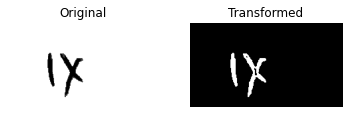

In [161]:
# Code from https://towardsdatascience.com/yatzy-score-sheet-detection-in-python-using-opencv-tensorflow-mnist-97ce685d80e0
def opencv_morph_ada_thresh(img):
    """ 
    Returns a binary image with adaptive threshold.
    """
    # Convert to grayscale
    img = np.asarray(img)

    # Apply Gaussian filter for smoothing effect of shadows etc. before adaptive threshold
    # We use 5x5 kernel with Sigma = 0, which gives us StD = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # See https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=gaussianblur#Mat%20getGaussianKernel(int%20ksize,%20double%20sigma,%20int%20ktype)
    gray = cv2.GaussianBlur(img, (5, 5), 0)

    # We use Adaptive threshold to get threshold values based on different regions.
    # We use blocksize 7 for region size and 4 as constant to subtract from the Gaussian weighted sum
    # https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    return cv2.adaptiveThreshold(gray, 255,  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 4)

show_single_transform(opencv_morph_ada_thresh)

Transformation successful


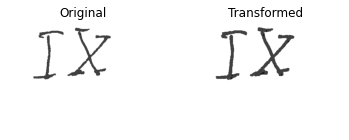

In [162]:
def opencv_morph_erode(img):
    """ 
    Erosion of image (Makes the black lines thicker)
    """
    # Convert to np array
    img = np.asarray(img)
    
    # Create a structuring element with opencv
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    img_transformed = cv2.erode(img, kernel, iterations=1)
    return img_transformed

show_single_transform(opencv_morph_erode)

Transformation successful


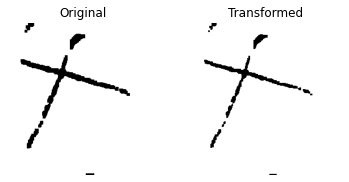

In [163]:
def opencv_morph_dilate(img):
    """ 
    Dilation of image (Makes the black lines thinner)
    """
    # Convert to np array
    img = np.asarray(img)

    # Create a structuring element with opencv
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    img_transformed = cv2.dilate(img, kernel, iterations=1)
    return img_transformed

show_single_transform(opencv_morph_dilate)

Transformation successful


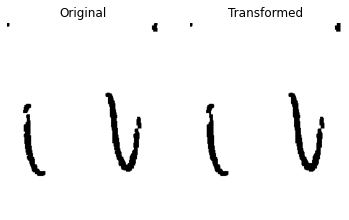

In [164]:
def opencv_morph_open(img):
    """ 
    Opening: Opening is the technique with erosion followed by dilation. 
    Opening is used to separate two structures in an image with a thin gap of the boundaries.
    """
    # Convert to np array
    img = np.asarray(img)
    # Create a structuring element with opencv
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    img_transformed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img_transformed

show_single_transform(opencv_morph_open)

Transformation successful


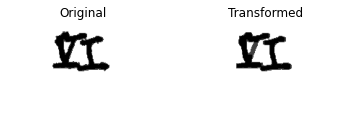

In [165]:
def opencv_morph_close(img):
    """ 
    Closing: Creates the opposite effect to that of opening by erosion followed by dilation. 
    Closing operation fills the small gaps in different structures making it close.
    """
    # Convert to np array
    img = np.asarray(img)
    # Create a structuring element with opencv
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    img_transformed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img_transformed

show_single_transform(opencv_morph_close)

___
#### Keep 4-way transformation as before (same as Version 4)

In [191]:
# No flip: iv, vi, vii, viii
transform_v7a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal flip only: v
transform_v7b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Vertical flip only: ix
transform_v7c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v7d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)

Transformation successful


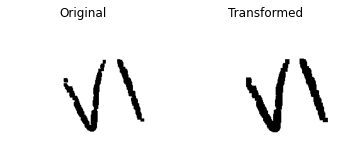

In [198]:
# Set morphological operation function for Version 7 augmentation
def opencv_morph_v1(img, k=3):
    """ 
    Weighted random selection of either dilaton or erosion (with higher weight to erosion)
    """
    # Convert to np array
    img = np.asarray(img)
    
    # Create a structuring element with opencv
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(k,k))
    morph_list = ['dilate', 'erosion']
    selected = random.choices(morph_list, weights=(25, 75), k=1)[0]
#     print(f'Performing {selected}')
    
    if selected == 'erosion':
        img_transformed = cv2.erode(img, kernel, iterations=1)
    else:
        img_transformed = cv2.dilate(img, kernel, iterations=1)
    
    return img_transformed

show_single_transform(opencv_morph_v1)

In [199]:
# # Maintain 80/20 train val split
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v7a, 
#                                aug_version='v07',
#                                train_size=800,
#                                extra_transform=opencv_morph_v1) # Include CV2 morphological operations
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v7b, 
#                                aug_version='v07',
#                                train_size=800,
#                                extra_transform=opencv_morph_v1)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v7c, 
#                                aug_version='v07',
#                                train_size=800,
#                                extra_transform=opencv_morph_v1)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                transform=transform_v7d, 
#                                aug_version='v07',
#                                train_size=800,
#                                extra_transform=opencv_morph_v1)

Created temp folder: ./data/2_augmented_v07/temp_i
1000
Created temp folder: ./data/2_augmented_v07/temp_ii
1000
Created temp folder: ./data/2_augmented_v07/temp_iii
1000
Created temp folder: ./data/2_augmented_v07/temp_iv
1000
Created temp folder: ./data/2_augmented_v07/temp_v
1000
Created temp folder: ./data/2_augmented_v07/temp_vi
1000
Created temp folder: ./data/2_augmented_v07/temp_vii
1000
Created temp folder: ./data/2_augmented_v07/temp_viii
1000
Created temp folder: ./data/2_augmented_v07/temp_ix
1000
Created temp folder: ./data/2_augmented_v07/temp_x
1000


___
<a name="v8"></a>
### Augmentation - Version 8
[Back to Top](#top)
___
**Description**
- Same as Version 6, but increase train/val split to  97.5/2.5 split

**Status**
- Submitted on 7 Aug 2021
- **Score: Bundle failed, submission cannot handle such extreme split**

In [201]:
# No flip: iv, vi, vii, viii
transform_v8a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True) # Cancel random order


# Horizontal flip only: v
transform_v8b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Vertical flip only: ix
transform_v8c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v8d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=True)

In [202]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v8a, 
#                                 aug_version='v08',
#                                 train_size=975)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v8b, 
#                                 aug_version='v08',
#                                 train_size=975)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v8c, 
#                                 aug_version='v08',
#                                 train_size=975)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v8d, 
#                                 aug_version='v08',
#                                 train_size=975)

Created temp folder: ./data/2_augmented_v08/temp_i
1000
Created temp folder: ./data/2_augmented_v08/temp_ii
1000
Created temp folder: ./data/2_augmented_v08/temp_iii
1000
Created temp folder: ./data/2_augmented_v08/temp_iv
1000
Created temp folder: ./data/2_augmented_v08/temp_v
1000
Created temp folder: ./data/2_augmented_v08/temp_vi
1000
Created temp folder: ./data/2_augmented_v08/temp_vii
1000
Created temp folder: ./data/2_augmented_v08/temp_viii
1000
Created temp folder: ./data/2_augmented_v08/temp_ix
1000
Created temp folder: ./data/2_augmented_v08/temp_x
1000


___
<a name="v9"></a>
### Augmentation - Version 9
[Back to Top](#top)
___
**Description**
- Use highest scoring version 5 as base for improvement i.e. remove random order, 80/20 split
- Introduce updated function `augment_images_shuffle_full_repr` to ensure all images are represented at least twice (same as original function of `augment_images`)
- Twice representation refers to original image + 1 transformed version of original image

**Status**
- Submitted on 13 Aug 2021
- **Score: __**

In [25]:
# No flip: iv, vi, vii, viii
transform_v9a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v9b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v9c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v9d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)

In [27]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v9a, 
#                                         aug_version='v09',
#                                         train_size=800)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v9b, 
#                                         aug_version='v09',
#                                         train_size=800)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v9c, 
#                                         aug_version='v09',
#                                         train_size=800)
        
#     else:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v9d, 
#                                         aug_version='v09',
#                                         train_size=800)

Created temp folder: ./data/2_augmented_v09/temp_i
1000
Created temp folder: ./data/2_augmented_v09/temp_ii
1000
Created temp folder: ./data/2_augmented_v09/temp_iii
1000
Created temp folder: ./data/2_augmented_v09/temp_iv
1000
Created temp folder: ./data/2_augmented_v09/temp_v
1000
Created temp folder: ./data/2_augmented_v09/temp_vi
1000
Created temp folder: ./data/2_augmented_v09/temp_vii
1000
Created temp folder: ./data/2_augmented_v09/temp_viii
1000
Created temp folder: ./data/2_augmented_v09/temp_ix
1000
Created temp folder: ./data/2_augmented_v09/temp_x
1000


___
<a name="v10"></a>
### Augmentation - Version 10
[Back to Top](#top)
___
**Description**
- Use highest scoring version 5 as base for improvement i.e. remove random order, 80/20 split
- Continue to use `augment_images_shuffle_full_repr` used from Version 9 (where every image is represented at least twice)
- Increase image to larger size (500 x 500)
- Begin more in depth augmentation experimentation
    - Include random perspective transform (warp image)
    - Reduce AdditiveGaussian noise from 0.05x255 to 0.035x225
    - Increase Multiply range to (0.5, 2) (Higher value = Brighter)
    - Increase rotation angle to (-25, 25)
    - Check out: https://imgaug.readthedocs.io/en/latest/source/overview/geometric.html

**Status**
- Submitted on 14 Aug 2021
- **Score: __**

Transformation successful


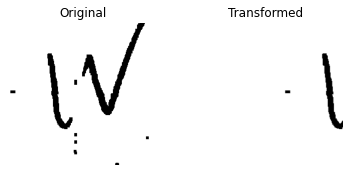

In [273]:
# Test effect of various new transformations
# sample_transform = iaa.PerspectiveTransform(scale=(0.04, 0.10))
# sample_transform = iaa.Multiply((2, 5), per_channel=0.2)
# sample_transform = iaa.LinearContrast((1.35, 1.75), per_channel=True)
# sample_transform = iaa.Crop(percent=(0.03, 0.13))
# sample_transform = iaa.AdditiveGaussianNoise(loc=0, scale=(0, 0.035*255), per_channel=0.5)
# sample_transform = iaa.GaussianBlur(sigma=(0, 0.7))
# sample_transform = iaa.Affine(translate_percent={"x": 0.2}, mode=ia.ALL, cval=(0, 255))
sample_transform = iaa.Affine(translate_percent={"x": 0.6}, mode=["edge"])

show_single_transform(sample_transform)

In [204]:
# No flip: iv, vi, vii, viii
transform_v10a = iaa.Sequential([
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.5, 2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v10b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.5, 2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v10c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.5, 2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v10d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.5, 2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)

In [205]:
# # Remove random order
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v10a, 
#                                         aug_version='v10',
#                                         train_size=800)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v10b, 
#                                         aug_version='v10',
#                                         train_size=800)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v10c, 
#                                         aug_version='v10',
#                                         train_size=800)
        
#     else:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v10d, 
#                                         aug_version='v10',
#                                         train_size=800)

Created temp folder: ./data/2_augmented_v10/temp_i
1000
Created temp folder: ./data/2_augmented_v10/temp_ii
1000
Created temp folder: ./data/2_augmented_v10/temp_iii
1000
Created temp folder: ./data/2_augmented_v10/temp_iv
1000
Created temp folder: ./data/2_augmented_v10/temp_v
1000
Created temp folder: ./data/2_augmented_v10/temp_vi
1000
Created temp folder: ./data/2_augmented_v10/temp_vii
1000
Created temp folder: ./data/2_augmented_v10/temp_viii
1000
Created temp folder: ./data/2_augmented_v10/temp_ix
1000
Created temp folder: ./data/2_augmented_v10/temp_x
1000


___
<a name="v11"></a>
### Augmentation - Version 11
[Back to Top](#top)
___
**Description**
- Build on Version 10
- Reduce flipud probability from 0.5 to 0.2
- Slightly increase shear from (-3,3) to (-6,6)
- Significantly remove the grayish background effect by changing Multiply from (0.5, 2) to (0.95, 1.5)

**Status**
- Submitted on 14 Aug 2021
- **Score: __**

In [285]:
# No flip: iv, vi, vii, viii
transform_v11a = iaa.Sequential([
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.95, 1.5), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-6, 6),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v11b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.95, 1.5), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-6, 6),
                        cval=255
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v11c = iaa.Sequential([
                    iaa.Flipud(0.2), # Vertical flip
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.95, 1.5), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-6, 6),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v11d = iaa.Sequential([
                    iaa.Flipud(0.2), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 500, "width": 500}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5, iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.PerspectiveTransform(scale=(0.04, 0.10)),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.035*255), per_channel=0.5),
                    iaa.Multiply((0.95, 1.5), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-25, 25),
                        shear=(-6, 6),
                        cval=255
                    )
                ], random_order=False)

In [286]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v11a, 
#                                         aug_version='v11',
#                                         train_size=800)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v11b, 
#                                         aug_version='v11',
#                                         train_size=800)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v11c, 
#                                         aug_version='v11',
#                                         train_size=800)
        
#     else:
#         augment_images_shuffle_full_repr(label=target_label, 
#                                         transform=transform_v11d, 
#                                         aug_version='v11',
#                                         train_size=800)

Created temp folder: ./data/2_augmented_v11/temp_i
1000
Created temp folder: ./data/2_augmented_v11/temp_ii
1000
Created temp folder: ./data/2_augmented_v11/temp_iii
1000
Created temp folder: ./data/2_augmented_v11/temp_iv
1000
Created temp folder: ./data/2_augmented_v11/temp_v
1000
Created temp folder: ./data/2_augmented_v11/temp_vi
1000
Created temp folder: ./data/2_augmented_v11/temp_vii
1000
Created temp folder: ./data/2_augmented_v11/temp_viii
1000
Created temp folder: ./data/2_augmented_v11/temp_ix
1000
Created temp folder: ./data/2_augmented_v11/temp_x
1000


___
<a name="v12"></a>
### Augmentation - Version 12
[Back to Top](#top)
___
**Description**  
- Build on version 5 to test any good from using adaptive (Otsu) thresholding for all images
- Not using the `augment_images_shuffle_full_repr` function here first

**Status**
- Submitted on 14 Aug 2021
- **Score: __**

In [83]:
def otsu_thresholding(img_original):
    img_original = np.asarray(img_original)
    thresh = threshold_otsu(img_original)
    mask = img_original > thresh
    img_transformed = np.zeros_like(img_original)
    img_transformed[mask] = img_original[mask]
    return img_transformed

Transformation successful


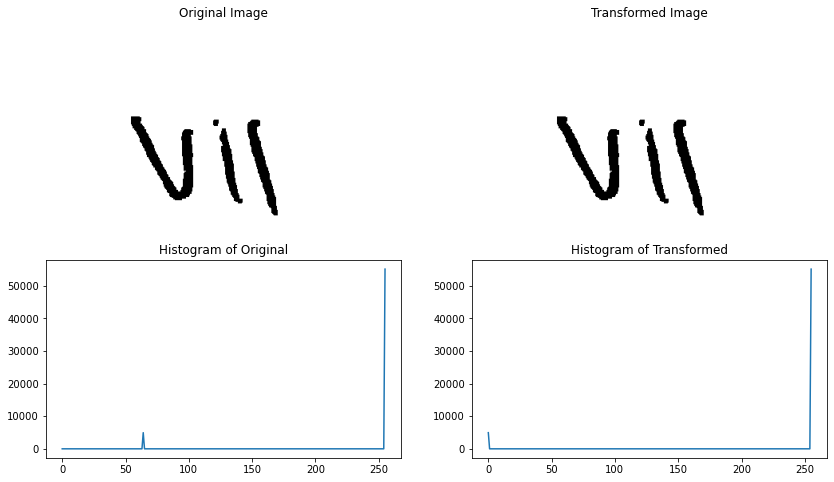

In [105]:
# Test effect of various new transformations
show_single_transform(otsu_thresholding, show_histogram=True)

In [107]:
# No flip: iv, vi, vii, viii
transform_v12a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v12b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v12c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v12d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)

In [108]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v12a, 
#                                 aug_version='v12',
#                                 train_size=800,
#                                 extra_transform=otsu_thresholding)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v12b, 
#                                 aug_version='v12',
#                                 train_size=800,
#                                 extra_transform=otsu_thresholding)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v12c, 
#                                 aug_version='v12',
#                                 train_size=800,
#                                 extra_transform=otsu_thresholding)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v12d, 
#                                 aug_version='v12',
#                                 train_size=800,
#                                 extra_transform=otsu_thresholding)

Created temp folder: ./data/2_augmented_v12/temp_i
1000
Created temp folder: ./data/2_augmented_v12/temp_ii
1000
Created temp folder: ./data/2_augmented_v12/temp_iii
1000
Created temp folder: ./data/2_augmented_v12/temp_iv
1000
Created temp folder: ./data/2_augmented_v12/temp_v
1000
Created temp folder: ./data/2_augmented_v12/temp_vi
1000
Created temp folder: ./data/2_augmented_v12/temp_vii
1000
Created temp folder: ./data/2_augmented_v12/temp_viii
1000
Created temp folder: ./data/2_augmented_v12/temp_ix
1000
Created temp folder: ./data/2_augmented_v12/temp_x
1000


___
<a name="v13"></a>
### Augmentation - Version 13
[Back to Top](#top)
___
**Description**
- Based on Version 5 (Not using `augment_images_shuffle_full_repr`)
- Test simple effect of reducing the flipud ratio (get less of unrealistic vertical flips of numbers like iii) from 0.5 to 0.15

**Status**
- Submitted on 14 Aug 2021
- **Score: __**

In [109]:
# No flip: iv, vi, vii, viii
transform_v13a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v13b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v13c = iaa.Sequential([
                    iaa.Flipud(0.15), # Vertical flip (Reduced to 0.15)
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v13d = iaa.Sequential([
                    iaa.Flipud(0.15), # Vertical flip (Reduced to 0.15)
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)

In [110]:
# target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x']
# labels_no_flip = ['iv','vi','vii','viii']
# labels_h_flip = ['v']
# labels_v_flip = ['ix']
# labels_h_and_v_flip = ['i','ii','iii','x']

# for target_label in target_labels:
#     if target_label in labels_no_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v13a, 
#                                 aug_version='v13',
#                                 train_size=800)
        
#     elif target_label in labels_h_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v13b, 
#                                 aug_version='v13',
#                                 train_size=800)
        
#     elif target_label in labels_v_flip:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v13c, 
#                                 aug_version='v13',
#                                 train_size=800)
        
#     else:
#         augment_images_shuffle(label=target_label, 
#                                 transform=transform_v13d, 
#                                 aug_version='v13',
#                                 train_size=800)

Created temp folder: ./data/2_augmented_v13/temp_i
1000
Created temp folder: ./data/2_augmented_v13/temp_ii
1000
Created temp folder: ./data/2_augmented_v13/temp_iii
1000
Created temp folder: ./data/2_augmented_v13/temp_iv
1000
Created temp folder: ./data/2_augmented_v13/temp_v
1000
Created temp folder: ./data/2_augmented_v13/temp_vi
1000
Created temp folder: ./data/2_augmented_v13/temp_vii
1000
Created temp folder: ./data/2_augmented_v13/temp_viii
1000
Created temp folder: ./data/2_augmented_v13/temp_ix
1000
Created temp folder: ./data/2_augmented_v13/temp_x
1000


___
<a name="v14"></a>
### Augmentation - Version 14
[Back to Top](#top)
___
**Description**
- Manually tag edge cases and increase their representation slightly
- Manually identify images that shouldnt be flipped


**Status**
- Submitted on __
- **Score: __**

___
<a name="v15"></a>
### Augmentation - Version 15
[Back to Top](#top)
___
**Description**
- test

**Status**
- Submitted on __
- **Score: __**

___
<a name="v16"></a>
### Augmentation - Version 16
[Back to Top](#top)
___
**Description**
- test

**Status**
- Submitted on __
- **Score: __**

___
<a name="v17"></a>
### Augmentation - Version 17
[Back to Top](#top)
___
**Description**
- test

**Status**
- Submitted on __
- **Score: __**

___
<a name="v18"></a>
### Augmentation - Version 18
[Back to Top](#top)
___
**Description**
- test

**Status**
- Submitted on __
- **Score: __**

___
<a name="v19"></a>
### Augmentation - Version 19
[Back to Top](#top)
___
**Description**
- test

**Status**
- Submitted on __
- **Score: __**

___

#### Spare Codes

In [ ]:
# # Create a custom Dataset class to read in data from folder
# class BreedDogDataset(Dataset):
#     def __init__(self, dataframe, root_dir, transform=None):
#         self.dataframe = dataframe
#         self.root_dir = root_dir
#         self.transform = transform
        
#     def __len__(self):
#         return (len(self.dataframe))
    
#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir,
#                   self.dataframe.iloc[idx, 0])
#         image = Image.open(img_name)
#         target = self.dataframe.iloc[idx, 1]
#         target_processed = breeds_processed_dict[target]
#         if self.transform:
#             image = self.transform(image)
#         sample = (image, target_processed)
#         return sample

# # Perform transformation on all images in train and val sets
# train_ds = BreedDogDataset(df_train,TRAIN_DIR, transform=transform)
# val_ds = BreedDogDataset(df_val,TRAIN_DIR, transform=transform)